<a href="https://colab.research.google.com/github/shahabafshar/MachineLearning/blob/main/HW1_ME5920_S26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - ME5920 Spring 2026

1. github address: https://github.com/shahabafshar/MachineLearning

## Setup
Install packages and import libraries.

In [1]:
# install packages needed for this assignment
!pip install einops torchvision

Load all the libraries we need.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from einops import rearrange
import torchvision
import cv2

Download MNIST digits and pick 1,000 random samples.

In [49]:
# download MNIST
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True)
X_all = mnist.data.numpy()
y_all = mnist.targets.numpy()

n_samples = 1000 # 1000 images

np.random.seed(2026)
idx = np.random.choice(len(X_all), n_samples, replace=False)
X = X_all[idx]   # each 28x28
y = y_all[idx]   # their labels (0-9)
print(f"X: {X.shape}, y: {y.shape}")

X: (1000, 28, 28), y: (1000,)


## 2.1 - MNIST Handwritten Digits

Show 5 sample digits from the dataset.

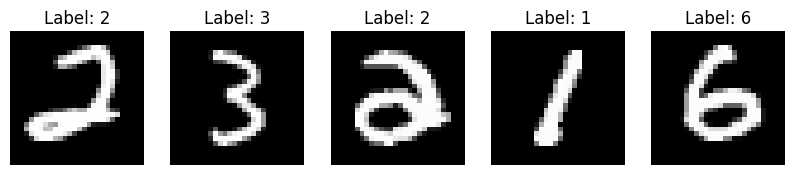

In [50]:
# 2.1a - show 5 sample digits
n_plt = 5
fig, axes = plt.subplots(1, n_plt, figsize=(10, 10/n_plt))
for j in range(n_plt):
    axes[j].imshow(X[j], cmap='gray')
    axes[j].set_title(f'Label: {y[j]}')
    axes[j].axis('off')
plt.show()

Histogram of how many times each digit (0-9) appears.

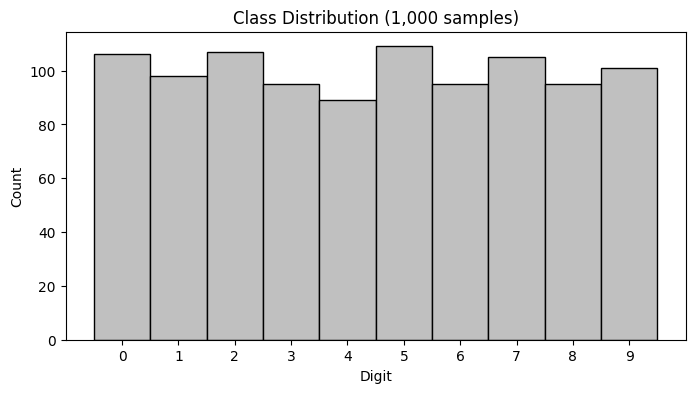

In [56]:
# 2.1b - how many of each digit do we have?
plt.figure(figsize=(8, 4))
plt.hist(y, bins=np.arange(11) - 0.5, color='silver', edgecolor='black')
plt.xticks(range(10))
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Class Distribution (1,000 samples)')
plt.show()

Group images into batches of 25 with shape (batches, 25, 1, 28, 28).

In [57]:
# 2.1c - reshape into batches of 25
# adds a channel dim: (1000,28,28) -> (40, 25, 1, 28, 28)
batched = rearrange(X, '(b n) h w -> b n 1 h w', n=25)
print(f"Original: {X.shape}")
print(f"Batched:  {batched.shape}")

Original: (1000, 28, 28)
Batched:  (40, 25, 1, 28, 28)


3D surface plot of a random digit - pixel values as height.

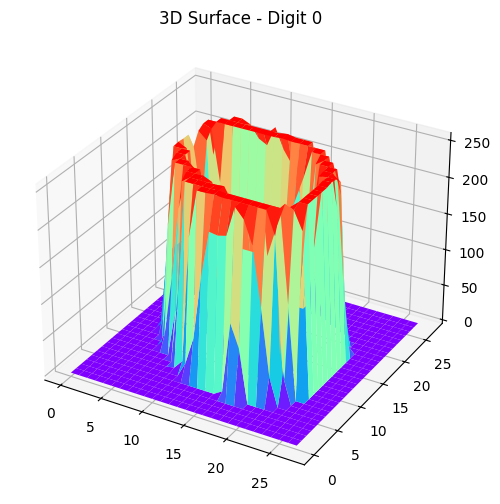

In [69]:
# 2.1d - 3D surface of a random digit (pixel value = height)
rand_idx = np.random.randint(0, len(X))
digit = X[rand_idx]

xx, yy = np.meshgrid(range(28), range(28))
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, digit, cmap='rainbow')
ax.set_title(f'3D Surface - Digit {y[rand_idx]}')
plt.show()

## 2.2 - Energy Consumption Time Series

Load the energy dataset from UCI and parse dates.

In [8]:
# 2.2a - load energy dataset from UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv'
energy = pd.read_csv(url)
energy['date'] = pd.to_datetime(energy['date'])  # parse dates
print(f"Shape: {energy.shape}")
print(f"Columns: {list(energy.columns[:5])}...")  # first 5 columns

Shape: (19735, 29)
Columns: ['date', 'Appliances', 'lights', 'T1', 'RH_1']...


Plot appliances energy over the full period, then zoom into one week.

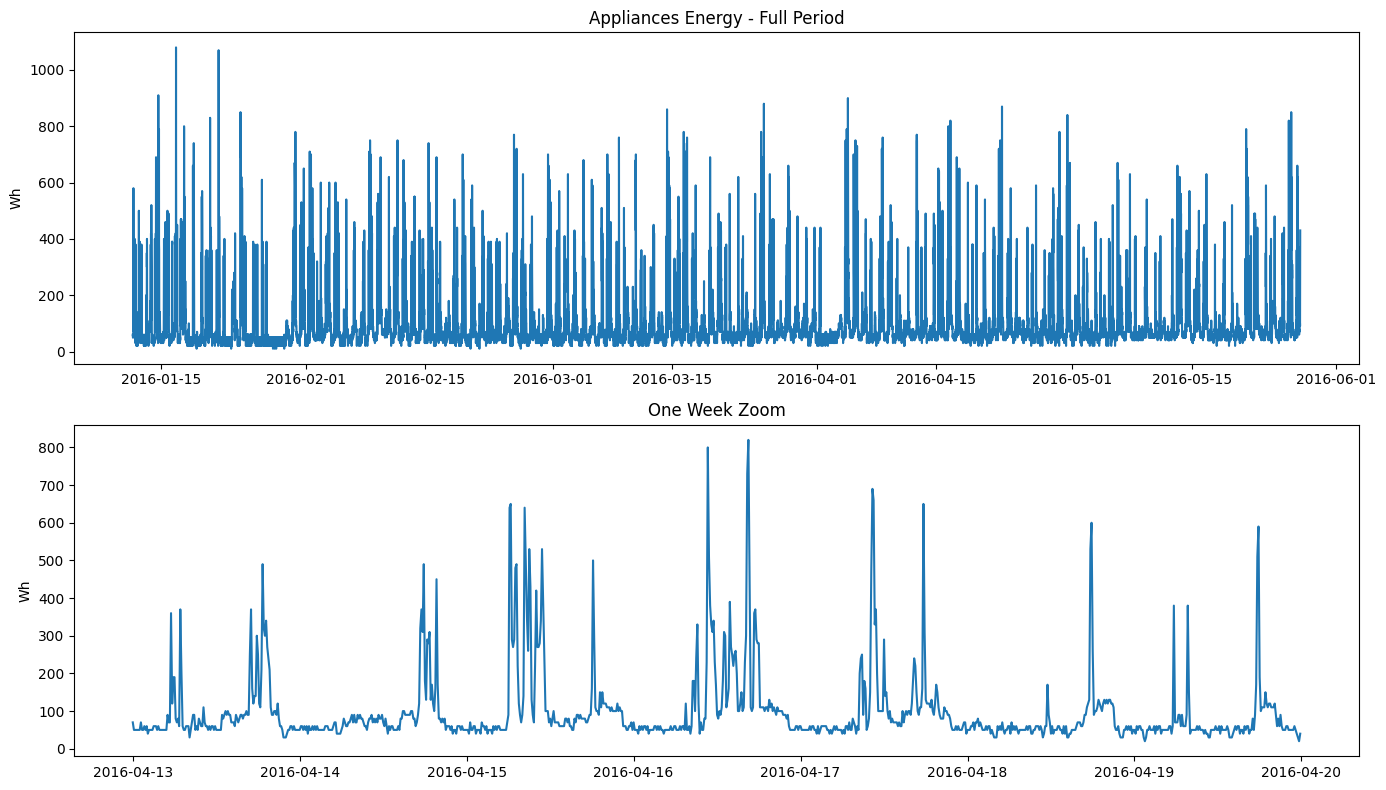

In [80]:
# 2.2b - plot full period + zoom into one week
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# full time range
axes[0].plot(energy['date'], energy['Appliances'])
axes[0].set_title('Appliances Energy - Full Period')
axes[0].set_ylabel('Wh')

# one week zoom
ws_date = pd.to_datetime('2016-04-13')
we_date = pd.to_datetime('2016-04-20')
week = energy[(energy['date'] >= ws_date) & (energy['date'] < we_date)]
axes[1].plot(week['date'], week['Appliances'])
axes[1].set_title('One Week Zoom')
axes[1].set_ylabel('Wh')

plt.tight_layout()
plt.show()

Heatmap of average hourly energy use by day of week (one week).

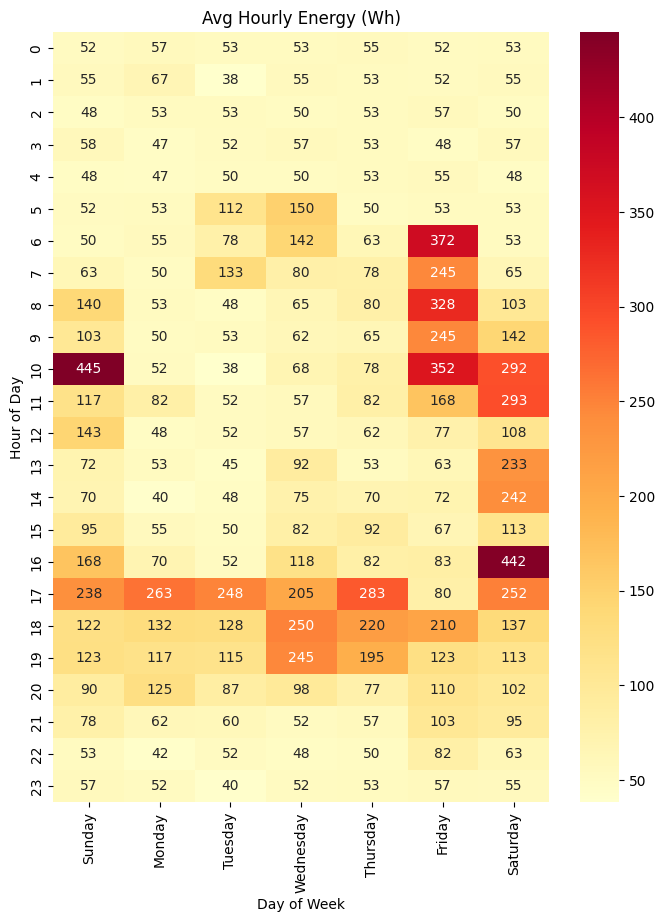

In [112]:
# 2.2c - heatmap: avg hourly energy by day of week
week = energy[(energy['date'] >= ws_date) & (energy['date'] < we_date)].copy()
week['hour'] = week['date'].dt.hour
week['dayofweek'] = week['date'].dt.day_name()

# pivot table: rows=hour, cols=day, values=avg energy
pivot = week.pivot_table(values='Appliances', index='hour', columns='dayofweek', aggfunc='mean')
day_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pivot = pivot[[d for d in day_order if d in pivot.columns]]

plt.figure(figsize=(8, 10))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Avg Hourly Energy (Wh)')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.show()


Histogram of appliances energy values.

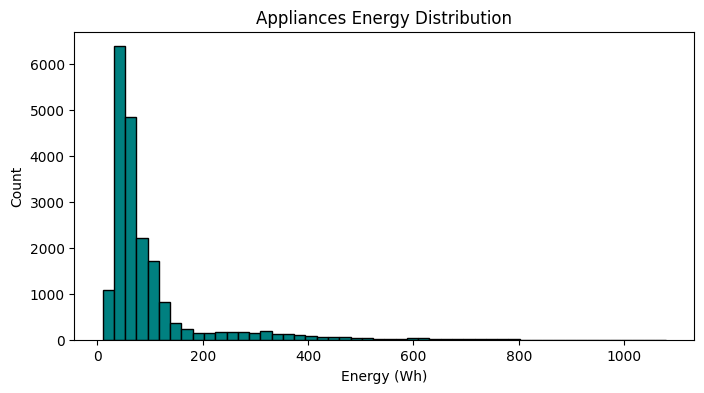

In [83]:
# 2.2d - distribution of appliances energy
plt.figure(figsize=(8, 4))
plt.hist(energy['Appliances'], bins=50, color='teal', edgecolor='black')
plt.xlabel('Energy (Wh)')
plt.ylabel('Count')
plt.title('Appliances Energy Distribution')
plt.show()

Create NSM (Number of Seconds from Midnight) from timestamps.

In [84]:
# 2.2e - compute NSM (number of seconds from midnight)
energy['NSM'] = (energy['date'].dt.hour * 3600
               + energy['date'].dt.minute * 60
               + energy['date'].dt.second)
print(f"NSM range: {energy['NSM'].min()} to {energy['NSM'].max()}")
energy[['date', 'NSM']].head(3)

NSM range: 0 to 85800


,date,NSM
0,2016-01-11 17:00:00,61200
1,2016-01-11 17:10:00,61800
2,2016-01-11 17:20:00,62400


Scatter plots: Appliances vs NSM and vs Press_mm_hg.

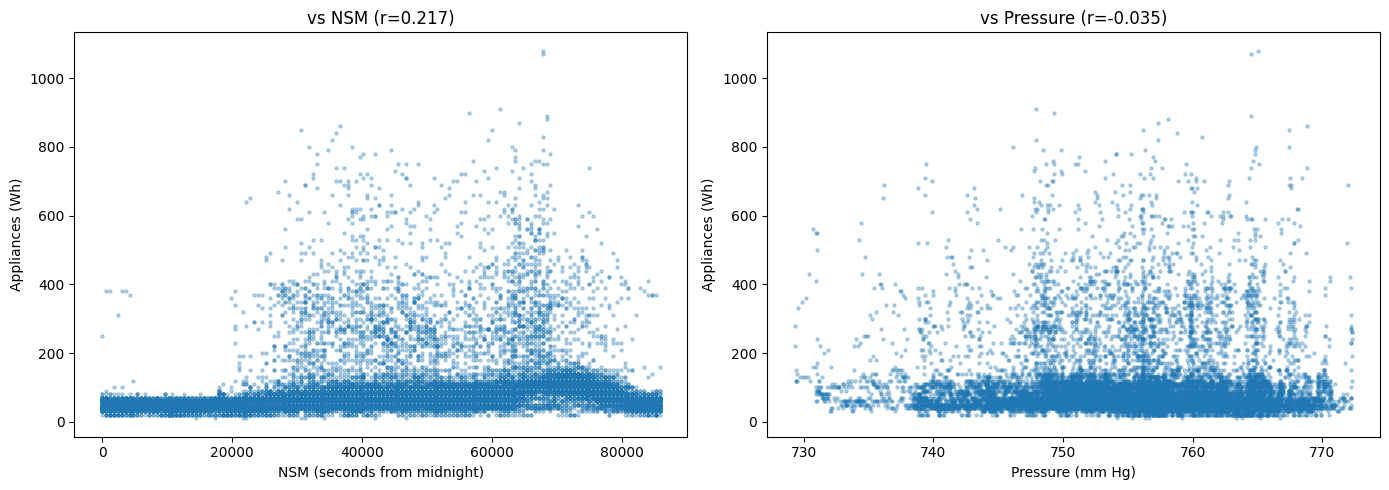

In [85]:
# 2.2f - scatter: appliances vs NSM and vs pressure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# appliances vs NSM
axes[0].scatter(energy['NSM'], energy['Appliances'], alpha=0.3, s=5)
axes[0].set_xlabel('NSM (seconds from midnight)')
axes[0].set_ylabel('Appliances (Wh)')
r1 = energy['NSM'].corr(energy['Appliances'])
axes[0].set_title(f'vs NSM (r={r1:.3f})')

# appliances vs pressure
axes[1].scatter(energy['Press_mm_hg'], energy['Appliances'], alpha=0.3, s=5)
axes[1].set_xlabel('Pressure (mm Hg)')
axes[1].set_ylabel('Appliances (Wh)')
r2 = energy['Press_mm_hg'].corr(energy['Appliances'])
axes[1].set_title(f'vs Pressure (r={r2:.3f})')

plt.tight_layout()
plt.show()

**Comment on NSM and Press_mm_hg as major contributing factors:**

NSM (number of seconds from midnight) captures the time-of-day effect on energy consumption. Appliance usage follows clear daily patterns — higher during waking/cooking hours and lower overnight — so NSM naturally correlates with consumption spikes.

Press_mm_hg (barometric pressure) acts as a proxy for weather conditions. Low pressure is associated with storms and colder weather, which increases heating and lighting demand. Higher pressure often accompanies clear, mild weather where less energy is needed indoors.

Together, these two features capture both the human behavioral cycle (when people use appliances) and the environmental driver (weather conditions that push energy use up or down), making them the strongest single predictors among the available features.


## 2.3 - Airfoil Self-Noise Dataset

Load the airfoil dataset and compute basic statistics for each feature.

In [86]:
# 2.3 - load airfoil data
from scipy import stats as sp_stats

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
cols = ['Frequency', 'Angle', 'ChordLength', 'Velocity', 'Displacement', 'Sound']
airfoil = pd.read_csv(url, sep='\t', header=None, names=cols)

# compute required stats
stats_df = pd.DataFrame({
    'Mean': airfoil.mean(),
    'Variance': airfoil.var(),
    'Median': airfoil.median(),
    'Kurtosis': airfoil.kurtosis(),
    'Skewness': airfoil.skew(),
    'Range': airfoil.max() - airfoil.min()
})
print(f"Shape: {airfoil.shape}")
stats_df.round(3)

Shape: (1503, 6)


,Mean,Variance,Median,Kurtosis,Skewness,Range
Frequency,2886.381,9938717.384,1600.000,5.709,2.137,19800.000
Angle,6.782,35.024,5.400,-0.413,0.689,22.200
ChordLength,0.137,0.009,0.102,-1.038,0.457,0.279
Velocity,50.861,242.512,39.600,-1.564,0.236,39.600
Displacement,0.011,0.000,0.005,2.219,1.702,0.058
Sound,124.836,47.591,125.721,-0.314,-0.419,37.607


## 3.1 – Image Processing (Leaf Image)

Load a leaf image and display it.

Saving Agricultural_Image_Analytics.zip to Agricultural_Image_Analytics.zip
Found 13 leaf images
Loaded 13 images


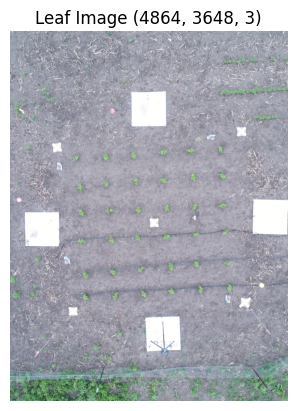

In [113]:
# 3.1a - upload and extract the leaf images
import zipfile, glob, os
from google.colab import files

uploaded = files.upload()  # upload "Agricultural and Image.zip"
zip_name = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall('leaf_data')

# find all image files in extracted folder
img_paths = sorted(
    glob.glob('leaf_data/**/*.jpg', recursive=True)
    + glob.glob('leaf_data/**/*.jpeg', recursive=True)
    + glob.glob('leaf_data/**/*.png', recursive=True)
    + glob.glob('leaf_data/**/*.JPG', recursive=True)
)
print(f"Found {len(img_paths)} leaf images")

# load all leaf images as RGB
leaf_images = []
for p in img_paths:
    img = cv2.imread(p)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        leaf_images.append(img)
print(f"Loaded {len(leaf_images)} images")

# show the first leaf
plt.imshow(leaf_images[0])
plt.title(f'Leaf Image {leaf_images[0].shape}')
plt.axis('off')
plt.show()


Generate 100 augmented images using random rotate, shift, and scale.

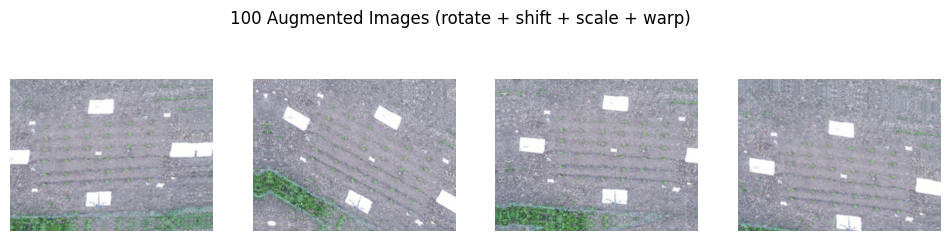

In [114]:
# 3.1b - generate 100 augmented images (rotate, shift, scale, warp)
from scipy.ndimage import rotate, shift, zoom

# pick one leaf image as the base for augmentation
img_base = leaf_images[0].copy()
h_img, w_img = img_base.shape[:2]
img_base = cv2.resize(img_base, (320, 240))
h_rs, w_rs = 240, 320

augmented = []
for _ in range(100):
    img = img_base.copy().astype(np.float64)

    # random rotate
    img = rotate(img, np.random.uniform(-30, 30), reshape=False, mode='reflect')

    # random shift
    dx, dy = np.random.uniform(-20, 20, size=2)
    img = shift(img, [dy, dx, 0], mode='reflect')

    # random scale
    s = np.random.uniform(0.8, 1.2)
    img = zoom(img, [s, s, 1], mode='reflect')
    img = cv2.resize(img.astype(np.float32), (w_rs, h_rs))

    # random affine warp (shear)
    shear_x = np.random.uniform(-0.15, 0.15)
    shear_y = np.random.uniform(-0.15, 0.15)
    M = np.array([[1, shear_x, 0],
                  [shear_y, 1, 0]], dtype=np.float32)
    img = cv2.warpAffine(img.astype(np.float32), M, (w_rs, h_rs),
                         borderMode=cv2.BORDER_REFLECT)

    augmented.append(img.astype(np.float64))

# show 4 examples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for j in range(4):
    axes[j].imshow(np.clip(augmented[j], 0, 255).astype(np.uint8))
    axes[j].axis('off')
plt.suptitle(f'{len(augmented)} Augmented Images (rotate + shift + scale + warp)')
plt.show()


Extract small patches from all 101 images (original + 100 augmented).

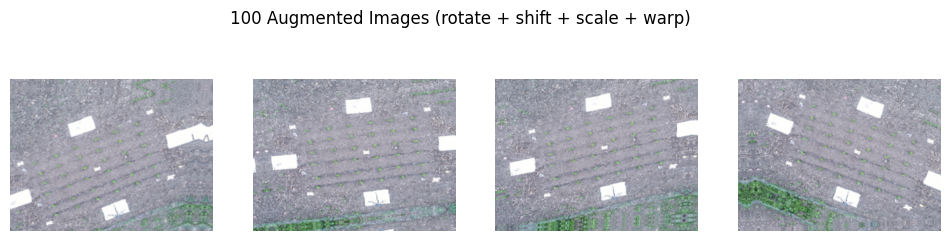

In [115]:
# 3.1b - generate 100 augmented images (rotate, shift, scale, warp)
from scipy.ndimage import rotate, shift, zoom

# pick one leaf image as the base for augmentation
img_base = leaf_images[0].copy()
h_img, w_img = img_base.shape[:2]
img_base = cv2.resize(img_base, (320, 240))
h_rs, w_rs = 240, 320

augmented = []
for _ in range(100):
    img = img_base.copy().astype(np.float64)

    # random rotate
    img = rotate(img, np.random.uniform(-30, 30), reshape=False, mode='reflect')

    # random shift
    dx, dy = np.random.uniform(-20, 20, size=2)
    img = shift(img, [dy, dx, 0], mode='reflect')

    # random scale
    s = np.random.uniform(0.8, 1.2)
    img = zoom(img, [s, s, 1], mode='reflect')
    img = cv2.resize(img.astype(np.float32), (w_rs, h_rs))

    # random affine warp (shear)
    shear_x = np.random.uniform(-0.15, 0.15)
    shear_y = np.random.uniform(-0.15, 0.15)
    M = np.array([[1, shear_x, 0],
                  [shear_y, 1, 0]], dtype=np.float32)
    img = cv2.warpAffine(img.astype(np.float32), M, (w_rs, h_rs),
                         borderMode=cv2.BORDER_REFLECT)

    augmented.append(img.astype(np.float64))

# show 4 examples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for j in range(4):
    axes[j].imshow(np.clip(augmented[j], 0, 255).astype(np.uint8))
    axes[j].axis('off')
plt.suptitle(f'{len(augmented)} Augmented Images (rotate + shift + scale + warp)')
plt.show()


Apply ZCA whitening to decorrelate the patch features.

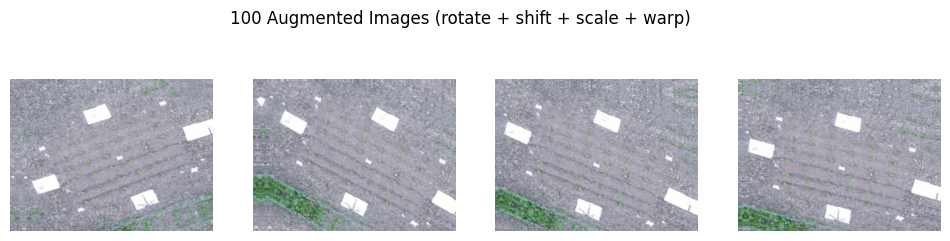

In [116]:
# 3.1b - generate 100 augmented images (rotate, shift, scale, warp)
from scipy.ndimage import rotate, shift, zoom

# pick one leaf image as the base for augmentation
img_base = leaf_images[0].copy()
h_img, w_img = img_base.shape[:2]
img_base = cv2.resize(img_base, (320, 240))
h_rs, w_rs = 240, 320

augmented = []
for _ in range(100):
    img = img_base.copy().astype(np.float64)

    # random rotate
    img = rotate(img, np.random.uniform(-30, 30), reshape=False, mode='reflect')

    # random shift
    dx, dy = np.random.uniform(-20, 20, size=2)
    img = shift(img, [dy, dx, 0], mode='reflect')

    # random scale
    s = np.random.uniform(0.8, 1.2)
    img = zoom(img, [s, s, 1], mode='reflect')
    img = cv2.resize(img.astype(np.float32), (w_rs, h_rs))

    # random affine warp (shear)
    shear_x = np.random.uniform(-0.15, 0.15)
    shear_y = np.random.uniform(-0.15, 0.15)
    M = np.array([[1, shear_x, 0],
                  [shear_y, 1, 0]], dtype=np.float32)
    img = cv2.warpAffine(img.astype(np.float32), M, (w_rs, h_rs),
                         borderMode=cv2.BORDER_REFLECT)

    augmented.append(img.astype(np.float64))

# show 4 examples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for j in range(4):
    axes[j].imshow(np.clip(augmented[j], 0, 255).astype(np.uint8))
    axes[j].axis('off')
plt.suptitle(f'{len(augmented)} Augmented Images (rotate + shift + scale + warp)')
plt.show()


Compare R, G, B channel distributions before and after whitening.

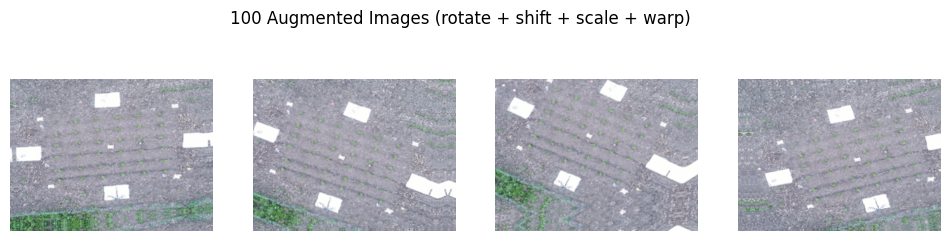

In [117]:
# 3.1b - generate 100 augmented images (rotate, shift, scale, warp)
from scipy.ndimage import rotate, shift, zoom

# pick one leaf image as the base for augmentation
img_base = leaf_images[0].copy()
h_img, w_img = img_base.shape[:2]
img_base = cv2.resize(img_base, (320, 240))
h_rs, w_rs = 240, 320

augmented = []
for _ in range(100):
    img = img_base.copy().astype(np.float64)

    # random rotate
    img = rotate(img, np.random.uniform(-30, 30), reshape=False, mode='reflect')

    # random shift
    dx, dy = np.random.uniform(-20, 20, size=2)
    img = shift(img, [dy, dx, 0], mode='reflect')

    # random scale
    s = np.random.uniform(0.8, 1.2)
    img = zoom(img, [s, s, 1], mode='reflect')
    img = cv2.resize(img.astype(np.float32), (w_rs, h_rs))

    # random affine warp (shear)
    shear_x = np.random.uniform(-0.15, 0.15)
    shear_y = np.random.uniform(-0.15, 0.15)
    M = np.array([[1, shear_x, 0],
                  [shear_y, 1, 0]], dtype=np.float32)
    img = cv2.warpAffine(img.astype(np.float32), M, (w_rs, h_rs),
                         borderMode=cv2.BORDER_REFLECT)

    augmented.append(img.astype(np.float64))

# show 4 examples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for j in range(4):
    axes[j].imshow(np.clip(augmented[j], 0, 255).astype(np.uint8))
    axes[j].axis('off')
plt.suptitle(f'{len(augmented)} Augmented Images (rotate + shift + scale + warp)')
plt.show()


## 3.2 - Image Segmentation (Soybean Subplots)

Load a plant image and convert to HSV color space.

In [118]:
# 3.2a - load soybean field images from the zip
soy_paths = sorted(
    glob.glob('leaf_data/**/*.jpg', recursive=True)
    + glob.glob('leaf_data/**/*.jpeg', recursive=True)
    + glob.glob('leaf_data/**/*.png', recursive=True)
    + glob.glob('leaf_data/**/*.JPG', recursive=True)
    + glob.glob('leaf_data/**/*.tif', recursive=True)
)
# filter for the soybean/field images (adjust path filter if needed)
soy_paths = [p for p in soy_paths if 'Image' in p or 'soy' in p.lower() or 'field' in p.lower()]
if len(soy_paths) == 0:
    soy_paths = sorted(
        glob.glob('leaf_data/**/*.jpg', recursive=True)
        + glob.glob('leaf_data/**/*.JPG', recursive=True)
        + glob.glob('leaf_data/**/*.png', recursive=True)
    )
print(f"Found {len(soy_paths)} soybean field images")
for p in soy_paths:
    print(f"  {p}")


Found 13 soybean field images
  leaf_data/Agricultural_Image_Analytics/1.JPG
  leaf_data/Agricultural_Image_Analytics/2.JPG
  leaf_data/Agricultural_Image_Analytics/3.JPG
  leaf_data/Agricultural_Image_Analytics/4.JPG
  leaf_data/Agricultural_Image_Analytics/5.JPG
  leaf_data/Agricultural_Image_Analytics/leaves/I1.png
  leaf_data/Agricultural_Image_Analytics/leaves/I2.png
  leaf_data/Agricultural_Image_Analytics/leaves/I3.png
  leaf_data/Agricultural_Image_Analytics/leaves/I4.png
  leaf_data/Agricultural_Image_Analytics/leaves/I5.png
  leaf_data/Agricultural_Image_Analytics/leaves/I6.png
  leaf_data/Agricultural_Image_Analytics/leaves/I7.png
  leaf_data/Agricultural_Image_Analytics/leaves/I8.png


Segment green areas using HSV thresholds.

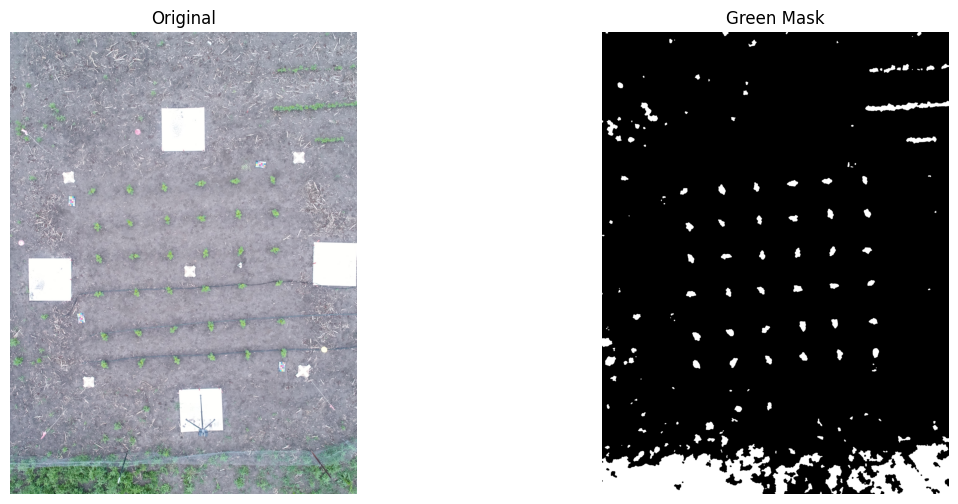

Detected 36 subplots (target: 36)


In [119]:
# 3.2b - segmentation pipeline to extract 36 soybean subplots
from scipy import ndimage

def segment_subplots(img_rgb, target_n=36):
    """Segment green soybean subplots from a drone field image.
    Returns bounding boxes sorted top-to-bottom, left-to-right."""

    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # HSV threshold for green vegetation
    lower = np.array([25, 30, 30])
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # morphology to clean up noise and merge nearby pixels
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k_open)

    # find connected components
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # get bounding boxes and filter by area
    areas = [cv2.contourArea(c) for c in contours]
    if len(areas) == 0:
        return [], mask

    # use median area to set a reasonable threshold
    med_area = np.median(sorted(areas, reverse=True)[:target_n * 2])
    min_area = med_area * 0.2

    bboxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) >= min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            bboxes.append((x, y, w, h))

    # if we have more than target, keep the largest ones
    if len(bboxes) > target_n:
        bboxes.sort(key=lambda b: b[2]*b[3], reverse=True)
        bboxes = bboxes[:target_n]

    # sort into grid: top-to-bottom, left-to-right
    centers_y = sorted(set([b[1] + b[3]//2 for b in bboxes]))
    if len(centers_y) > 1:
        row_gap = np.median(np.diff(centers_y)) * 0.5
    else:
        row_gap = 50

    bboxes.sort(key=lambda b: (round((b[1] + b[3]//2) / max(row_gap, 1)), b[0]))

    return bboxes, mask

# test on first soybean image
test_img = cv2.imread(soy_paths[0])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
bboxes, mask = segment_subplots(test_img)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(test_img); axes[0].set_title('Original'); axes[0].axis('off')
axes[1].imshow(mask, cmap='gray'); axes[1].set_title('Green Mask'); axes[1].axis('off')
plt.show()
print(f"Detected {len(bboxes)} subplots (target: 36)")


Find green regions and draw numbered bounding boxes.

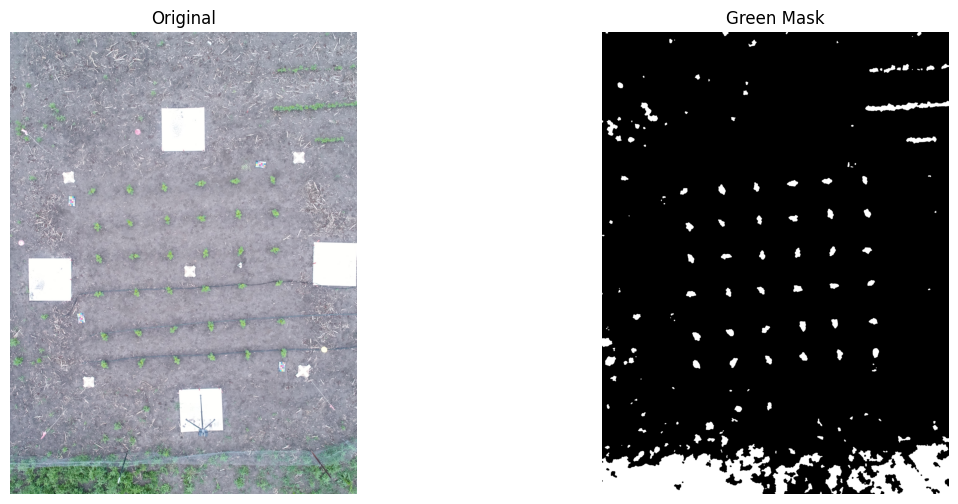

Detected 36 subplots (target: 36)


In [120]:
# 3.2b - segmentation pipeline to extract 36 soybean subplots
from scipy import ndimage

def segment_subplots(img_rgb, target_n=36):
    """Segment green soybean subplots from a drone field image.
    Returns bounding boxes sorted top-to-bottom, left-to-right."""

    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # HSV threshold for green vegetation
    lower = np.array([25, 30, 30])
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # morphology to clean up noise and merge nearby pixels
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k_open)

    # find connected components
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # get bounding boxes and filter by area
    areas = [cv2.contourArea(c) for c in contours]
    if len(areas) == 0:
        return [], mask

    # use median area to set a reasonable threshold
    med_area = np.median(sorted(areas, reverse=True)[:target_n * 2])
    min_area = med_area * 0.2

    bboxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) >= min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            bboxes.append((x, y, w, h))

    # if we have more than target, keep the largest ones
    if len(bboxes) > target_n:
        bboxes.sort(key=lambda b: b[2]*b[3], reverse=True)
        bboxes = bboxes[:target_n]

    # sort into grid: top-to-bottom, left-to-right
    centers_y = sorted(set([b[1] + b[3]//2 for b in bboxes]))
    if len(centers_y) > 1:
        row_gap = np.median(np.diff(centers_y)) * 0.5
    else:
        row_gap = 50

    bboxes.sort(key=lambda b: (round((b[1] + b[3]//2) / max(row_gap, 1)), b[0]))

    return bboxes, mask

# test on first soybean image
test_img = cv2.imread(soy_paths[0])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
bboxes, mask = segment_subplots(test_img)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(test_img); axes[0].set_title('Original'); axes[0].axis('off')
axes[1].imshow(mask, cmap='gray'); axes[1].set_title('Green Mask'); axes[1].axis('off')
plt.show()
print(f"Detected {len(bboxes)} subplots (target: 36)")
